In [1]:
# %load init.ipy
# NOTE: This is for when the notebook is converted to a python script
# NOTE: this MUST precede the magic functions
def get_ipython():
    return type('Dummy', (object,), dict(run_line_magic=lambda *args, **kwargs: None))
    
%reload_ext autoreload
%autoreload 2

# %load init.ipy
import os, sys, logging, datetime, warnings, shutil
from importlib import reload

import numpy as np
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from nose import tools

import tqdm
import memory_profiler as mpro

import kalepy as kale
import kalepy.utils
import kalepy.plot
from kalepy.plot import nbshow   # NOTE: this should be upgraded to `plot_control`
from kalepy.plot import plot_control

def _save_fig(fig, fname, **kwargs):
    kwargs.setdefault('path', kale._PATH_NB_OUT)
    kwargs.setdefault('rename', True)
    return kale.plot._save_fig(fig, fname, **kwargs)
    
save_fig = _save_fig

In [2]:
# import kalepy as kale
# import kalepy.plot
# from kalepy import utils
# from kalepy.utils import trapz_dens_to_mass
# from kalepy.plot import nbshow

# Edge Construction

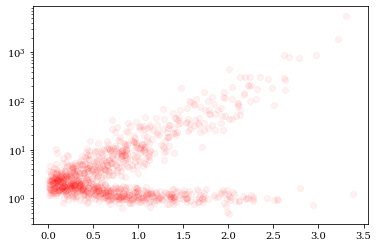

In [34]:
SIZE = 1e3

SIZE = int(SIZE)
xx = np.random.normal(0.0, 1.0, SIZE)
yy = 10**np.random.normal(xx, 0.2, SIZE)
xx = np.fabs(xx + np.random.normal(0.0, 0.2, SIZE))
yy += 10.0**np.random.normal(0.0, 0.1, SIZE)
data = [xx, yy]

# plt.scatter(xx, yy, color='b', alpha=0.25)
ax = plt.gca()
ax.set(xscale='linear', yscale='log')

plt.scatter(*data, color='r', alpha=0.05)

plt.show()

In [37]:
# reload(kale.utils)
# des = kale.utils.Data_Edges(data)

# Trapezoid Integration

(2, 3000)
(20, 30)
True
True


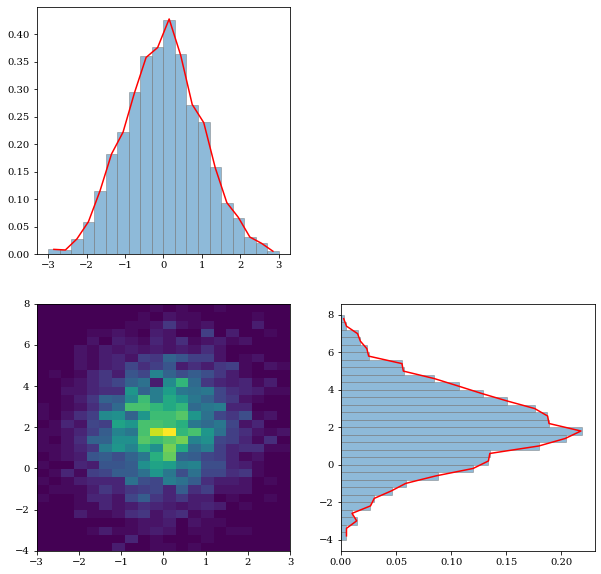

In [3]:
nbins = [20, 30]
xx = np.linspace(-3.0, 3.0, nbins[0]+1)
yy = np.linspace(-4.0, 8.0, nbins[1]+1)

xc = kale.utils.midpoints(xx, 'lin')
yc = kale.utils.midpoints(yy, 'lin')

grid = np.meshgrid(xx, yy)
zz = np.random.multivariate_normal([0.0, 2.0], [[1.0, 0.2],[0.2, 4.0]], 3000).T
print(zz.shape)

fig, axes = plt.subplots(figsize=[10, 10], ncols=2, nrows=2)
axes[0, 1].set_visible(False)
axes = [axes[1, 0], axes[0, 0], axes[1, 1]]
# axes = [ax for ii, ax in enumerate(axes.flatten()) if ii != 1]

ax = axes[0]
grid_cc = np.meshgrid(xc, yc)
# the `density` parameter in `hist2d` is incompatible with python3.5
# pdf, *_ = ax.hist2d(zz[0].flatten(), zz[1].flatten(), bins=(xx, yy), density=True)
pdf, *_ = np.histogram2d(zz[0].flatten(), zz[1].flatten(), bins=(xx, yy), density=True)
ax.pcolormesh(*grid, pdf.T)
print(pdf.shape)


ax = axes[1]
xpdf, *_ = ax.hist(zz[0].flatten(), bins=xx, density=True, alpha=0.5, edgecolor='0.5')

proj_pdf = kale.utils.trapz_nd(pdf, [xc, yc], axis=1)
print(np.allclose(xpdf, proj_pdf, rtol=1e-1))
ax.plot(xc, proj_pdf, 'r-')

ax = axes[2]
ypdf, *_ = ax.hist(zz[1].flatten(), bins=yy, orientation='horizontal', density=True, alpha=0.5, edgecolor='0.5')

proj_pdf = kale.utils.trapz_nd(pdf, [xc, yc], axis=0)
print(np.allclose(ypdf, proj_pdf, rtol=1e-1))
ax.plot(proj_pdf, yc, 'r-')

nbshow()

(2, 3000)
(20, 30)
True
True


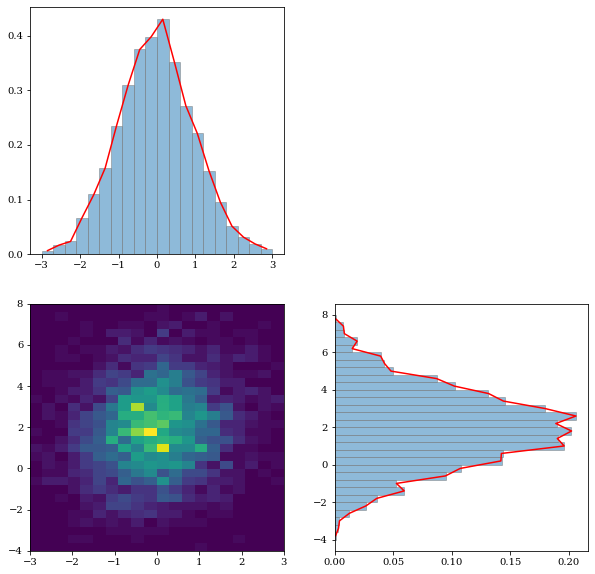

In [4]:
nbins = [20, 30]
xx = np.linspace(-3.0, 3.0, nbins[0]+1)
yy = np.linspace(-4.0, 8.0, nbins[1]+1)

xc = kale.utils.midpoints(xx, 'lin')
yc = kale.utils.midpoints(yy, 'lin')

grid = np.meshgrid(xx, yy)
zz = np.random.multivariate_normal([0.0, 2.0], [[1.0, 0.2],[0.2, 4.0]], 3000).T
print(zz.shape)

fig, axes = plt.subplots(figsize=[10, 10], ncols=2, nrows=2)
axes[0, 1].set_visible(False)
axes = [axes[1, 0], axes[0, 0], axes[1, 1]]
# axes = [ax for ii, ax in enumerate(axes.flatten()) if ii != 1]

ax = axes[0]
# pdf, *_ = ax.hist2d(zz[0].flatten(), zz[1].flatten(), bins=(xx, yy), density=True)
pdf, *_ = np.histogram2d(zz[0].flatten(), zz[1].flatten(), bins=(xx, yy), density=True)
ax.pcolormesh(*grid, pdf.T)
print(pdf.shape)


ax = axes[1]
xpdf, *_ = ax.hist(zz[0].flatten(), bins=xx, density=True, alpha=0.5, edgecolor='0.5')

proj_pdf = kale.utils.trapz_nd(pdf, [xc, yc], axis=1)
print(np.allclose(xpdf, proj_pdf, rtol=1e-1))
ax.plot(xc, proj_pdf, 'r-')

ax = axes[2]
ypdf, *_ = ax.hist(zz[1].flatten(), bins=yy, orientation='horizontal', density=True, alpha=0.5, edgecolor='0.5')

proj_pdf = kale.utils.trapz_nd(pdf, [xc, yc], axis=0)
print(np.allclose(ypdf, proj_pdf, rtol=1e-1))
ax.plot(proj_pdf, yc, 'r-')

nbshow()

In [5]:
def _test_ndim_a1(ndim):
    from kalepy import utils

    BIN_SIZE_RANGE = [10, 30]
    num_bins = np.random.randint(*BIN_SIZE_RANGE, ndim)
    # num_bins = [3, 4]
    
    edges = []
    extr = []
    for nb in num_bins:
        ee = np.cumsum(np.random.uniform(0.0, 2.0, nb))
        edges.append(ee)
    
    grid = np.meshgrid(*edges, indexing='ij')
    shp = [len(ee) for ee in edges]
    
    for axis in range(ndim):
        not_axis = (axis + 1) % 2
        print("\nndim = {}, axis = {}, other = {}".format(ndim, axis, not_axis))

        bcast_norm = [np.newaxis for ii in range(ndim)]
        bcast_norm[not_axis] = slice(None)
        bcast_norm = tuple(bcast_norm)
        norm = np.random.uniform(0.0, 10.0, shp[not_axis])[bcast_norm]

        bcast_wids = [np.newaxis for ii in range(ndim)]
        bcast_wids[axis] = slice(None)
        bcast_wids = tuple(bcast_wids)
        wids = np.diff(edges[axis])[bcast_wids]
        
        pdf = np.ones_like(grid[0]) * norm     
        pmf = kale.utils.trapz_dens_to_mass(pdf, edges, axis=axis)

        new_shp = [ss for ss in shp]
        new_shp[axis] -= 1
        kale.utils.alltrue(np.shape(pmf) == np.array(new_shp), "Output shape is {fail:}correct")
    
        kale.utils.alltrue(pmf == norm*wids, 'Values do {fail:}match')
        
        # print(pdf)
        # print(wids)
        # print(pmf)
        
    return

for ii in range(2, 5):
    _test_ndim_a1(ii)


ndim = 2, axis = 0, other = 1
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 2, axis = 1, other = 0
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 3, axis = 0, other = 1
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 3, axis = 1, other = 0
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 3, axis = 2, other = 1
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 4, axis = 0, other = 1
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 4, axis = 1, other = 0
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 4, axis = 2, other = 1
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 4, axis = 3, other = 0
SUCCESS:: Output shape is correct
SUCCESS:: Values do match


In [6]:
def _test_ndim_a2(ndim):
    from kalepy import utils

    BIN_SIZE_RANGE = [10, 30]
    num_bins = np.random.randint(*BIN_SIZE_RANGE, ndim)
    # num_bins = [3, 4, 5]
    
    edges = []
    extr = []
    for nb in num_bins:
        ee = np.cumsum(np.random.uniform(0.0, 2.0, nb))
        edges.append(ee)
    
    grid = np.meshgrid(*edges, indexing='ij')
    shp = np.array([len(ee) for ee in edges])
    
    for axis in np.ndindex(*([ndim]*2)):
        if len(np.unique(axis)) != len(axis):
            continue
        
        axis = np.asarray(axis)
        not_axis = np.array(list(set(range(ndim)) - set(axis)))
        print("\nndim = {}, axis = {}, other = {}".format(ndim, axis, not_axis))
        
        bcast_norm = [np.newaxis for ii in range(ndim)]
        for na in not_axis:
            bcast_norm[na] = slice(None)

        bcast_norm = tuple(bcast_norm)
        print(bcast_norm)
        norm = np.random.uniform(0.0, 10.0, shp[not_axis])[bcast_norm]

        bcast_wids = [np.newaxis for ii in range(ndim)]
        for aa in axis:
            bcast_wids[aa] = slice(None)

        bcast_wids = tuple(bcast_wids)

        widths = []
        for ii in range(ndim):
            dim_len_inn = shp[ii]
            if ii in axis:
                wid = np.diff(edges[ii])
            else:
                wid = np.ones(dim_len_inn)

            # Create new axes along all by the current dimension, slice along the current dimension
            cut = [np.newaxis for ii in range(ndim)]
            cut[ii] = slice(None)
            temp = wid[tuple(cut)]
            widths.append(temp)
        
        wids = np.product(widths, axis=0)        
        
        pdf = np.ones_like(grid[0]) * norm     
        pmf = kale.utils.trapz_dens_to_mass(pdf, edges, axis=axis)

        new_shp = [ss for ss in shp]
        for aa in axis:
            new_shp[aa] -= 1

        kale.utils.alltrue(np.shape(pmf) == np.array(new_shp), "Output shape is {fail:}correct")
    
        kale.utils.alltrue(pmf == norm*wids, 'Values do {fail:}match')
        
        # print(pdf)
        # print(wids)
        # print(pmf)
        
    return

for ii in range(3, 5):
    _test_ndim_a2(ii)


ndim = 3, axis = [0 1], other = [2]
(None, None, slice(None, None, None))
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 3, axis = [0 2], other = [1]
(None, slice(None, None, None), None)
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 3, axis = [1 0], other = [2]
(None, None, slice(None, None, None))
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 3, axis = [1 2], other = [0]
(slice(None, None, None), None, None)
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 3, axis = [2 0], other = [1]
(None, slice(None, None, None), None)
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 3, axis = [2 1], other = [0]
(slice(None, None, None), None, None)
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 4, axis = [0 1], other = [2 3]
(None, None, slice(None, None, None), slice(None, None, None))
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 4, axis = [0 2], oth

# Bound Indices

# ND cumsum

In [7]:
def pad(aa, axis=None):
    if axis is None:
        return np.pad(aa, [1, 0])
    
    aa = np.moveaxis(aa, axis, 0)
    aa = np.concatenate([[np.zeros_like(aa[0])], aa], axis=0)
    aa = np.moveaxis(aa, 0, axis)
    return aa

aa = np.random.randint(0, 10, (3, 4, 2))
print(aa.shape)
for ax in [None, 0, 1, 2]:
    bb = pad(aa, ax)
    print(ax, bb.shape)
    # print(bb)
    print()
    

(3, 4, 2)
None (4, 5, 3)

0 (4, 4, 2)

1 (3, 5, 2)

2 (3, 4, 3)

